# WARNING - NEEDS TESTING - MAY BE MATH AND/OR CODE ERRORS - DON'T USE FOR REAL LIFE

## Extending CHIME to model dynamic relative contact rates
The [original CHIME model]() was intended for early stages of the Covid-19 pandemic when the spread of the virus was still growing and had not yet peaked. In Version 1.1.3, users could enter a date of mitigation corresponding to to when social distancing went into effect. After this date, the value of $\beta$ used in the SIR computations was reduced according to the value of the `relative-contact-rate` parameter input by the user. It was kind of like a light switch that you could use one time. However, as social distancing really took hold, hospital admits and census of Covid-19 patients began to decline and the relevant questions for hospitals quickly became:

- what will happen when social distancing policies are relaxed?
- will there be a second peak?
- when might a second peak occur and how long will it last?

Of course, answers to these questions are likely to depend quite a bit on how the relaxation of social distancing polices plays out. 

As a quick and dirty approach to starting to explore these questions, I decided to extend CHIME to accept a csv file containing `relative-contact-rate` values by date. With these we could model more realistic "ramp up" and "ramp down" changes in social distancing behavior. Of course, no one really knows how these rates will change in response to various state policies, but by at least doing a better job of matching the current ramp up and bending in hospital admissions and census, we might be able to do a decent job of setting these rates to make projections as social distancing policies change.

## Adding dynamic relative contact rates to sim_chime_scenario_runner

Several weeks ago I had created a simple Python wrapper application for CHIME called [sim_chime_scenario_runner](https://github.com/misken/sim_chime_scenario_runner). It added a bunch of little niceties that we wanted for doing scenario exploration with CHIME. You can read about the details [here](https://github.com/misken/c19#sim_chime_scenario_runnerpy) and there's a demo notebook [here](https://github.com/misken/sim_chime_scenario_runner/blob/master/demos/using_sim_chime_scenario_runner.ipynb).

This notebook assumes you have a basic familiarity with `sim_chime_scenario_runner` as I'm building the new dynamic relative contact rate (dynamic-rcr for short) functionality into it.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [23]:
%matplotlib inline

### The dynamic-rcr input file

Here's what an example input file looks like. It's just a csv file. The '#' is a comment and the rest of the line is ignored by the file reader (it's just pandas `read_csv`).

    date,relative_contact_rate
    # Filename: rcr_guess4_gappy.csv
    # first date must match date-first-hospitalized
    2020-02-20,0.00
    2020-03-21,0.25
    2020-03-22,0.35
    2020-03-24,0.45
    2020-03-26,0.50
    2020-03-28,0.55
    2020-03-30,0.60
    2020-04-01,0.65
    2020-04-03,0.70
    2020-04-05,0.75
    2020-04-30,0.70
    2020-05-03,0.60
    2020-05-10,0.45
    2020-05-30,0.35
    2020-06-30,0.25
    2020-08-31,0.15


Each relative contact rate (`rcr`) is in effect starting on the date specified until is changed. For example, an `rcr` of 0.70 is in effect from 2020-04-30 - 2020-05-02. It changes to 0.60 on 2020-05-03. A file that looks like the following is essentially what CHIME can currently handle - one date in which the `rcr` changes from 0 to some value > 0.

    date,relative_contact_rate
    # Filename: rcr_1mit.csv
    # first date must match date-first-hospitalized
    2020-02-20,0.00
    2020-03-21,0.55
    


## Running a few scenarios

Let's run two scenarios, one for each of the two dynamic-rcr files shown above.

Here's the standard CHIME config file I'll use for the two scenarios. The filename is `semi_0408_fddt_losplus.cfg`. A few things to note about the config file when using a dynamic-rcr file:

- both the `date-first-hospitalized` and initial `doubling-time` should be specified,
- you can leave the `mitigation-date` and `relative-contact-rate` lines in there but their values will be overridden by the dynamic-rcr file values (and of course, there can be many mitigation dates and rates).
 
        --population 5026226
        --market-share 0.30
        --current-hospitalized 1096
        --date-first-hospitalized 2020-02-20
        --doubling-time 3.290295710120783
        --mitigation-date 2020-03-21
        --current-date 2020-04-08
        --relative-contact-rate 0.54
        --hospitalized-rate 0.025
        --icu-rate 0.0075
        --ventilated-rate 0.005
        --infectious-days 10
        --hospitalized-day 8
        --icu-days 10
        --ventilated-day 10
        --n-days 120
        --recovered 0

### Scenario 1: A single mitigation date

For this first scenario, we'll use the following `dynamic-rcr` file.

    date,relative_contact_rate
    # Filename: rcr_1mit.csv
    # first date must match date-first-hospitalized
    2020-02-20,0.00
    2020-03-21,0.55
    
We'll use `sim_chime_scenario_runner` from the command line (it can also be used as importable module - see [demo notebook](https://github.com/misken/sim_chime_scenario_runner/blob/master/demos/using_sim_chime_scenario_runner.ipynb)). I've pip installed it from my local git repo. Here's the help:

In [24]:
!sim_chime_scenario_runner --help

usage: sim_chime_scenario_runner [-h] [--scenario SCENARIO]
                                 [--output-path OUTPUT_PATH]
                                 [--market-share MARKET_SHARE]
                                 [--dynamic-rcr DYNAMIC_RCR] [--admits ADMITS]
                                 [--actual ACTUAL] [--experiment EXPERIMENT]
                                 [--quiet]
                                 parameters

sim chime scenario runner

positional arguments:
  parameters            CHIME config (cfg) file

optional arguments:
  -h, --help            show this help message and exit
  --scenario SCENARIO   Prepended to output filenames. (default is current
                        datetime)
  --output-path OUTPUT_PATH
                        location for output file writing
  --market-share MARKET_SHARE
                        csv file containing date and market share (<=1.0)
  --dynamic-rcr DYNAMIC_RCR
                        csv file containing dates and relative contact r

Okay, let's run the one mitigation date scenario. Note that we are including actual admit and census data so we can compare with projections.

In [25]:
# scenario = 'test_1mit'
!sim_chime_scenario_runner semi_0408_fddt_losplus.cfg --scenario test_1mit --dynamic-rcr rcr_1mit.csv --actual semi_actual_0414.csv --output-path ./output/

2020-04-21 20:01:53,000 - penn_chime.model.parameters - INFO - Using file: semi_0408_fddt_losplus.cfg
2020-04-21 20:01:53,004 - sim_chime_scenario_runner.sirplus - INFO - Using date_first_hospitalized: 2020-02-20; current_date: 2020-04-08; i_day: 48, current_hospitalized: 1096
2020-04-21 20:01:53,010 - sim_chime_scenario_runner.sirplus - INFO - len(np.arange(-i_day, n_days+1)): 169
2020-04-21 20:01:53,010 - sim_chime_scenario_runner.sirplus - INFO - len(raw_df): 169
Scenario: test_1mit


Input parameters
--------------------------------------------------
{
    "current_date": "2020-04-08",
    "current_hospitalized": 1096,
    "date_first_hospitalized": "2020-02-20",
    "doubling_time": 3.290295710120783,
    "hospitalized": [
        8,
        0.025
    ],
    "icu": [
        10,
        0.0075
    ],
    "infectious_days": 10,
    "market_share": 0.3,
    "max_y_axis": null,
    "mitigation_date": "2020-03-21",
    "n_days": 120,
    "population": 5026226,
    "region": null,
    

Here's all the output files created. Again, see [demo notebook](https://github.com/misken/sim_chime_scenario_runner/blob/master/demos/using_sim_chime_scenario_runner.ipynb) for more details on all the outputs created.

In [26]:
!ls ./output/*.csv | grep 'test_1mit'

./output/test_1mit_adm_cen_long.csv
./output/test_1mit_adm_cen_wide.csv
./output/test_1mit_admits.csv
./output/test_1mit_census.csv
./output/test_1mit_dispositions.csv
./output/test_1mit_sim_sir_enhanced_df.csv
./output/test_1mit_sim_sir_w_date.csv


The `test_1mit_adm_cen_wide.csv` file is designed for easy plotting with matplotlib.

In [27]:
# Read data and set x and y arrays
test_1mit_df = pd.read_csv('./output/test_1mit_adm_cen_wide.csv', 
                                  parse_dates=['date'],
                                  index_col=0)
x = np.array(test_1mit_df.index.values)
y_actual_admits = np.array(test_1mit_df.covid_admits)
y_actual_census = np.array(test_1mit_df.covid_census)
y_adm_test_1mit = np.array(test_1mit_df.admits_hospitalized)
y_cen_test_1mit = np.array(test_1mit_df.census_hospitalized)

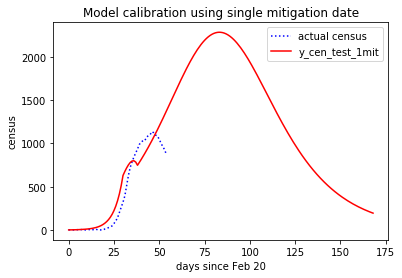

In [28]:
# Do census comparison

plt.plot(x, y_actual_census, 'b:', label = 'actual census')
plt.plot(x, y_cen_test_1mit, 'r-', label = 'y_cen_test_1mit')
plt.title('Model calibration using single mitigation date')
plt.xlabel('days since Feb 20')
plt.ylabel('census')
plt.legend()
plt.savefig("model_calibration_cen_test_1mit.png")
plt.show()

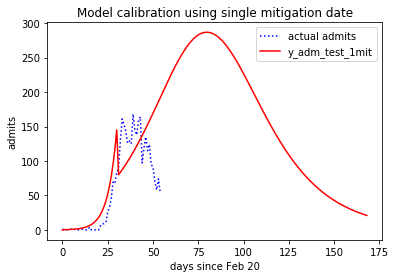

In [29]:
# Do admit comparison

plt.plot(x, y_actual_admits, 'b:', label = 'actual admits')
plt.plot(x, y_adm_test_1mit, 'r-', label = 'y_adm_test_1mit')
plt.title('Model calibration using single mitigation date')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.savefig("model_calibration_adm_test_1mit.png")
plt.show()

### Scenario 2: Multiple mitigation dates

For the second scenario, we'll use the following `dynamic-rcr` file.

    date,relative_contact_rate
    # Filename: rcr_guess4_gappy.csv
    # first date must match date-first-hospitalized
    2020-02-20,0.00
    2020-03-21,0.25
    2020-03-22,0.35
    2020-03-24,0.45
    2020-03-26,0.50
    2020-03-28,0.55
    2020-03-30,0.60
    2020-04-01,0.65
    2020-04-03,0.70
    2020-04-05,0.75
    2020-04-30,0.70
    2020-05-03,0.60
    2020-05-10,0.45
    2020-05-30,0.35
    2020-06-30,0.25
    2020-08-31,0.15
    


Okay, let's run the multiple mitigation date scenario. Note that again we are including actual admit and census data so we can compare with projections.

In [30]:
# scenario = 'rcr_guess4_gappy'
!sim_chime_scenario_runner semi_0408_fddt_losplus.cfg --scenario rcr_guess4_gappy --dynamic-rcr rcr_guess4_gappy.csv --actual semi_actual_0414.csv --output-path ./output/

2020-04-21 20:01:54,256 - penn_chime.model.parameters - INFO - Using file: semi_0408_fddt_losplus.cfg
2020-04-21 20:01:54,261 - sim_chime_scenario_runner.sirplus - INFO - Using date_first_hospitalized: 2020-02-20; current_date: 2020-04-08; i_day: 48, current_hospitalized: 1096
2020-04-21 20:01:54,268 - sim_chime_scenario_runner.sirplus - INFO - len(np.arange(-i_day, n_days+1)): 169
2020-04-21 20:01:54,268 - sim_chime_scenario_runner.sirplus - INFO - len(raw_df): 169
Scenario: rcr_guess4_gappy


Input parameters
--------------------------------------------------
{
    "current_date": "2020-04-08",
    "current_hospitalized": 1096,
    "date_first_hospitalized": "2020-02-20",
    "doubling_time": 3.290295710120783,
    "hospitalized": [
        8,
        0.025
    ],
    "icu": [
        10,
        0.0075
    ],
    "infectious_days": 10,
    "market_share": 0.3,
    "max_y_axis": null,
    "mitigation_date": "2020-03-21",
    "n_days": 120,
    "population": 5026226,
    "region": nul

Here's all the output files created. Again, see [demo notebook](https://github.com/misken/sim_chime_scenario_runner/blob/master/demos/using_sim_chime_scenario_runner.ipynb) for more details on all the outputs created.

In [35]:
!ls ./output/*.csv | grep 'rcr_guess4_gappy'

./output/rcr_guess4_gappy_adm_cen_long.csv
./output/rcr_guess4_gappy_adm_cen_wide.csv
./output/rcr_guess4_gappy_admits.csv
./output/rcr_guess4_gappy_census.csv
./output/rcr_guess4_gappy_dispositions.csv
./output/rcr_guess4_gappy_sim_sir_enhanced_df.csv
./output/rcr_guess4_gappy_sim_sir_w_date.csv


In [32]:
# Read data and set x and y arrays
rcr_guess4_gappy_df = pd.read_csv('./output/rcr_guess4_gappy_adm_cen_wide.csv', 
                                  parse_dates=['date'],
                                  index_col=0)
x = np.array(rcr_guess4_gappy_df.index.values)
y_actual_admits = np.array(rcr_guess4_gappy_df.covid_admits)
y_actual_census = np.array(rcr_guess4_gappy_df.covid_census)
y_adm_rcr_guess4_gappy = np.array(rcr_guess4_gappy_df.admits_hospitalized)
y_cen_rcr_guess4_gappy = np.array(rcr_guess4_gappy_df.census_hospitalized)

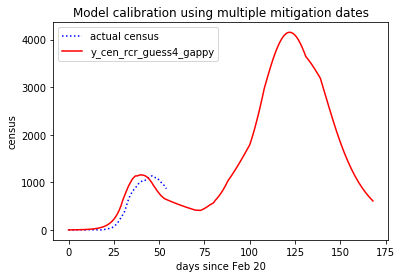

In [33]:
# Do census comparison

plt.plot(x, y_actual_census, 'b:', label = 'actual census')
plt.plot(x, y_cen_rcr_guess4_gappy, 'r-', label = 'y_cen_rcr_guess4_gappy')
plt.title('Model calibration using multiple mitigation dates')
plt.xlabel('days since Feb 20')
plt.ylabel('census')
plt.legend()
plt.savefig("model_calibration_cen_rcr_guess4_gappy.png")
plt.show()

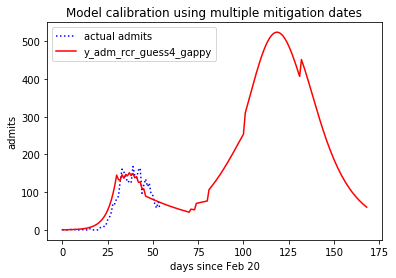

In [34]:
# Do admit comparison

plt.plot(x, y_actual_admits, 'b:', label = 'actual admits')
plt.plot(x, y_adm_rcr_guess4_gappy, 'r-', label = 'y_adm_rcr_guess4_gappy')
plt.title('Model calibration using multiple mitigation dates')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.savefig("model_calibration_adm_rcr_guess4_gappy.png")
plt.show()

## Implementation sketch
In the current version of CHIME, the user specified `mitigation-date` and `relative-contact-rate` are used in the `gen_policy()` method of the `Sir` class (both of which live in the module `sir.py` found in `src/penn_chime/model/`). The `gen_policy()` method creates a list of two tuples, `(beta, n_days)`, containing the $\beta$ values for before and after the `mitigation-date` and the number of days for which each $\beta$ is in effect. The resulting list looks like this ($\beta_{1}$ is in effect for first 30 days and then $\beta_{2}$ is in effect until the end of the simulation, 138 days later):

    [(2.1885788284312043e-07, 30), (9.848604727940418e-08, 138)]
    
These beta values are passed to `sim_sir` which then uses in the main `sir()` function which does a single step of the SIR simulation. Depending on which day it is (i.e. before or after the mitigation date), it either uses the first or the second `beta` value in the list of above.

In order to handle multiple mitigation dates, while still not touching the base `penn_chime` code, I subclassed their `Sir` class with a new class called `SirPlus` that lives in `sirplus.py` in my `sim_chime_scenario_runner` module. That class has a method called `get_betas` that takes the dataframe of dynamic relative contact rates described above and generates a list of `(beta, n_days)` tuples analagous to `Sir.gen_policy()`. The main module of `sim_chime_scenario_runner` handles reading the `dynamic-rcr` csv file into a pandas dataframe. Of course, there can be more than two tuples in the resulting list. Then, this list of policy tuples is passed to the CHIME `sim_sir` function and away we go. Remember, `sim_chime_scenario_runner` is just a wrapper (with extensions) for CHIME and uses the installed CHIME modules whenever possible. The `SirPlus` class is only used by `sim_chime_scenario_runner` if the user 
specifies that a `dynamic-rcr` file should be used. Otherwise, the standard CHIME `Sir` class is used.    


## Next steps
Obviously, the usefulness will depend in part on how well we can model various policy scenarios through the mitigation dates and relative contact values. Still tons of uncertainty as to values of basic model inputs and work continues by the CHIME folks on a Bayesian version that directly address such uncertainties. This work on dynamic relative contact rates just provides another set of easily interpetable modeling degrees of freedom for exploring the potential outcomes of various social distancing policies.

Much more to do, but wanted to get this idea out there for feedback.

<font size="2">This material is made available under the [MIT License](https://opensource.org/licenses/MIT).</font>